importation du dataset

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, confusion_matrix, classification_report
)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Charger le dataset d'origine
df = pd.read_excel("/content/dataset.xlsx")

Dimensions et types de données du dataset

In [ ]:
print("Dimensions du dataset :", df.shape)
print("\nTypes de données :\n", df.dtypes)

Dimensions du dataset : (1000, 17)

Types de données :
 ID_Etudiant                   int64
Note_Trimestre              float64
Nb_Notes_Sous_10              int64
Nb_Redoublements              int64
Remarques_Disciplinaires      int64
Participation_Classe         object
Absences_Non_Justifiees       int64
Nombre_Retard                 int64
Accessibilite_Transport      object
Zone_Habitation              object
Distance_Domicile_Ecole     float64
Temps_Trajet                  int64
Situation_Familiale          object
Revenu_Familial               int64
Comportement                 object
Clarte_Objectifs             object
risque_Abandon                int64
dtype: object


Convertir la colonne risque_Abandon en booléen

In [ ]:
df['risque_Abandon'] = df['risque_Abandon'].astype(bool)
print("\nNouveaux types de données :\n", df.dtypes)


Nouveaux types de données :
 ID_Etudiant                   int64
Note_Trimestre              float64
Nb_Notes_Sous_10              int64
Nb_Redoublements              int64
Remarques_Disciplinaires      int64
Participation_Classe         object
Absences_Non_Justifiees       int64
Nombre_Retard                 int64
Accessibilite_Transport      object
Zone_Habitation              object
Distance_Domicile_Ecole     float64
Temps_Trajet                  int64
Situation_Familiale          object
Revenu_Familial               int64
Comportement                 object
Clarte_Objectifs             object
risque_Abandon                 bool
dtype: object


Répartition des élèves selon le risque de décrochage

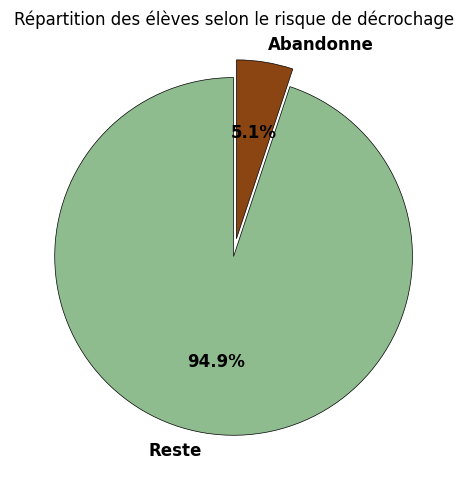

In [ ]:
df['risque_Abandon'].value_counts().plot.pie(
    autopct='%1.1f%%',
    labels=['Reste', 'Abandonne'],
    colors=['#8FBC8F', '#8B4513'],
    explode=(0, 0.1),
    title='Répartition des élèves selon le risque de décrochage',
    figsize=(5, 5),
    startangle=90,
    textprops={'fontsize': 12, 'weight': 'bold'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5}
)

plt.ylabel('')
plt.tight_layout()
plt.show()

Encodage des colonnes catégorielles

In [ ]:
# Identifier les colonnes catégorielles
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Initialiser les encodeurs et stocker les mappings
label_encoders = {}
df_encoded = df.copy()

# Encoder chaque colonne catégorielle
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# Sauvegarder le nouveau dataset encodé
df_encoded.to_excel('dataset_encoded.xlsx', index=False)

# Afficher les mappings pour chaque colonne
print("Mappings des valeurs catégorielles encodées:")
for col, mapping in label_encoders.items():
    print(f"\nColonne: {col}")
    for key, value in mapping.items():
        print(f"{key} -> {value}")

Mappings des valeurs catégorielles encodées:


Analyse de corrélation

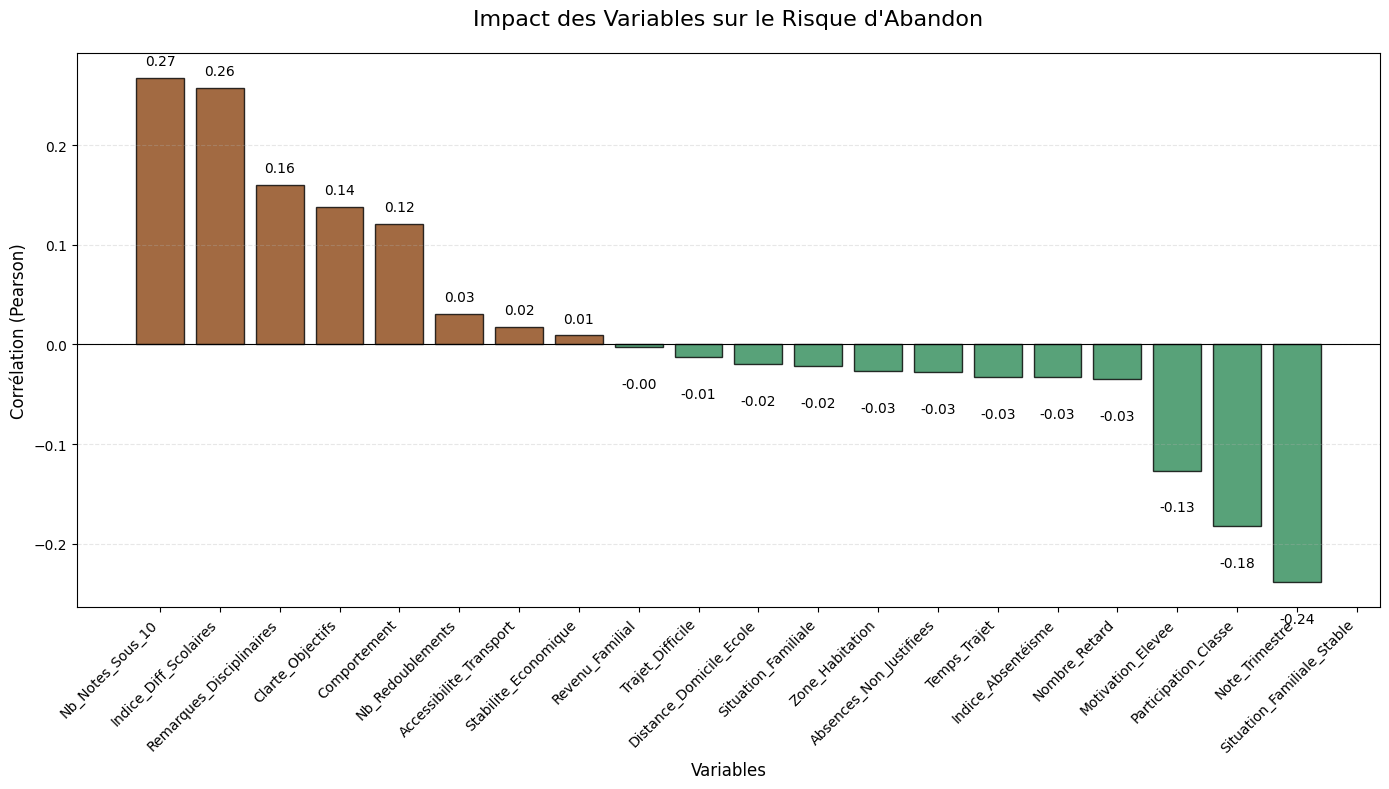

In [ ]:
#Analyse de corrélation
plt.figure(figsize=(14, 8))

# Colonnes à exclure
cols_to_exclude = ['ID_Etudiant', 'Label_Abandon']
df_corr = df_encoded.drop(columns=[col for col in cols_to_exclude if col in df_encoded.columns])

# Vérification que la variable cible existe
if 'risque_Abandon' not in df_corr.columns:
    raise ValueError("'risque_Abandon' n'existe pas dans le DataFrame")

# Calcul des corrélations
corr_series = df_corr.corr()['risque_Abandon'].sort_values(ascending=False)
corr_series = corr_series.drop('risque_Abandon', errors='ignore')

# Visualisation
bars = plt.bar(
    x=corr_series.index,
    height=corr_series.values,
    color=['#8B4513' if x > 0 else '#2E8B57' for x in corr_series],
    edgecolor='black',
    alpha=0.8
)


plt.title('Impact des Variables sur le Risque d\'Abandon', fontsize=16, pad=20)
plt.xlabel('Variables', fontsize=12)
plt.ylabel('Corrélation (Pearson)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.,
             height + 0.01 if height > 0 else height - 0.03,
             f"{height:.2f}",
             ha='center',
             va='bottom' if height > 0 else 'top',
             fontsize=10)

plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()


Décrochage selon la zone géographique


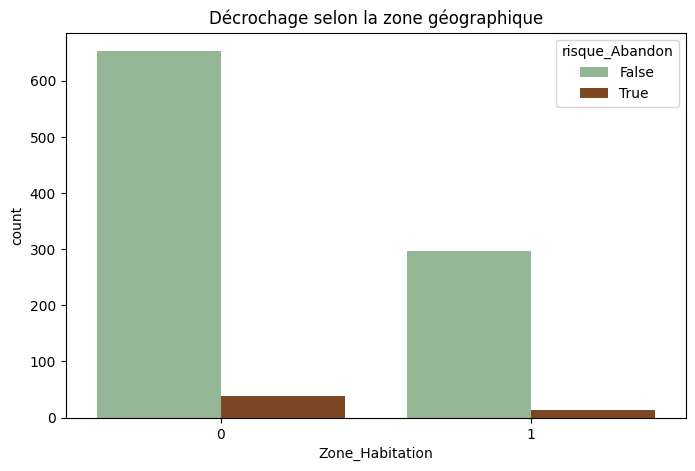

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(
    data=df,
    x='Zone_Habitation',
    hue='risque_Abandon',
    palette=['#8FBC8F', '#8B4513']
)
plt.title('Décrochage selon la zone géographique')
plt.show()


Lien entre revenu familial et moyenne

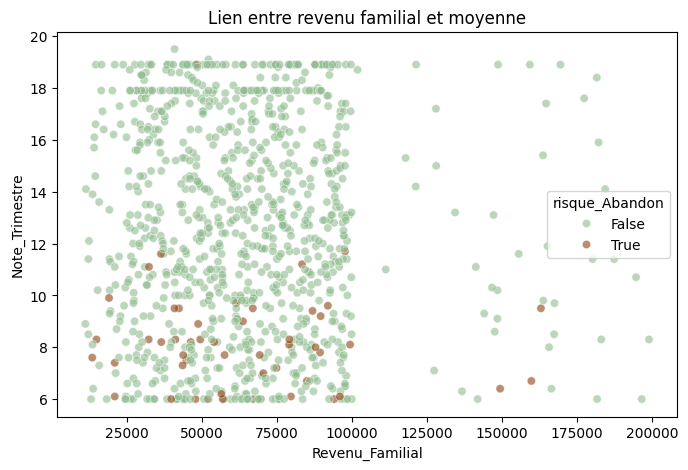

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x='Revenu_Familial',
    y='Note_Trimestre',
    hue='risque_Abandon',
    palette=['#8FBC8F', '#8B4513'],
    alpha=0.6
)
plt.title('Lien entre revenu familial et moyenne')
plt.show()

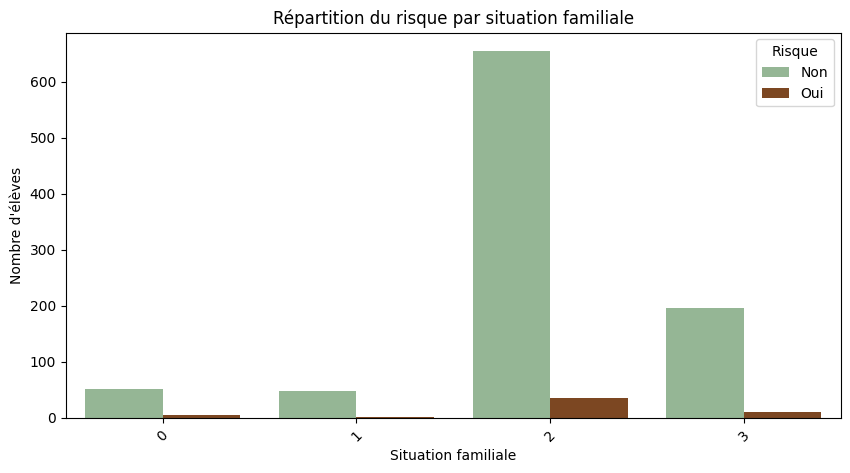

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(
    data=df,
    x='Situation_Familiale',
    hue='risque_Abandon',
    palette=['#8FBC8F', '#8B4513']
plt.title('Répartition du risque par situation familiale')
plt.xlabel('Situation familiale')
plt.ylabel('Nombre d\'élèves')
plt.xticks(rotation=45)
plt.legend(title='Risque', labels=['Non', 'Oui'])
plt.show()

Calcul de corrélation

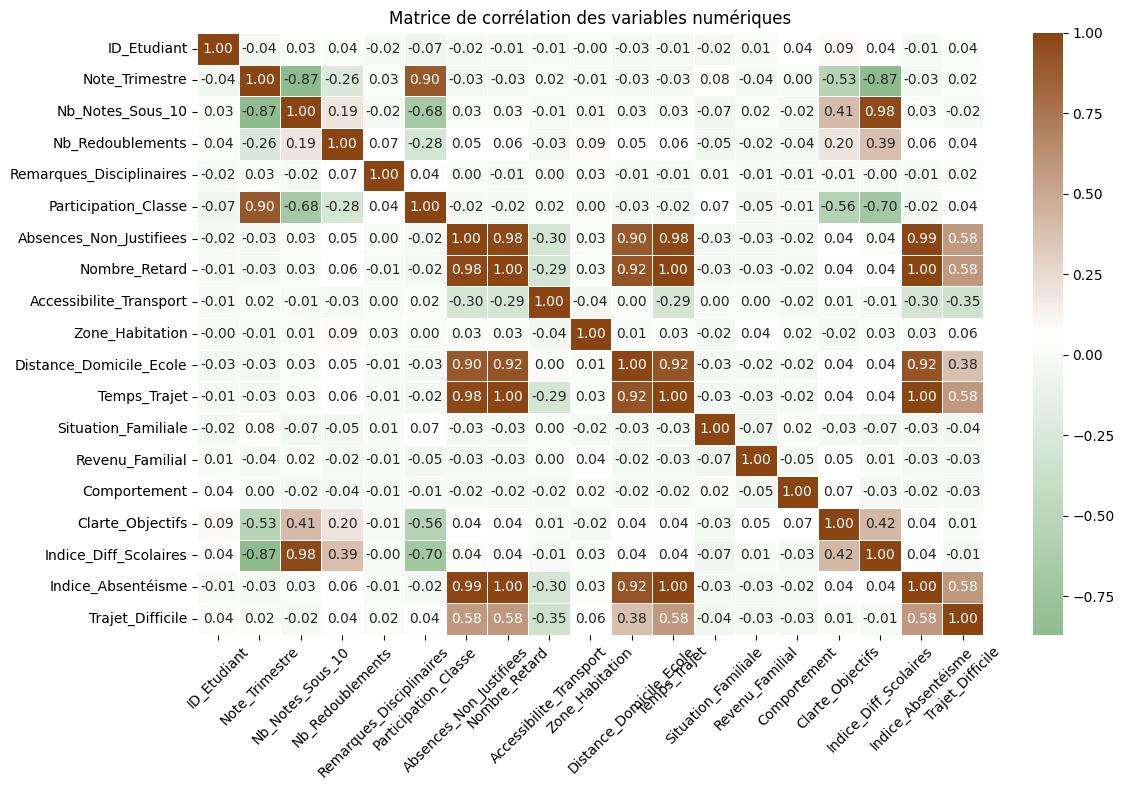

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Charger les données
df = pd.read_excel("dataset_encoded.xlsx")

# Sélection des colonnes numériques
df_numeric = df.select_dtypes(include='number')

# Calcul de la corrélation
correlation_matrix = df_numeric.corr()


plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap=sns.blend_palette(["#8FBC8F", "white", "#8B4513"], as_cmap=True),
    fmt=".2f",
    linewidths=0.5
)
plt.title("Matrice de corrélation des variables numériques")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Analyse des valeurs manquantes

In [ ]:
df.isnull().sum()

,0
ID_Etudiant,0
Note_Trimestre,0
Nb_Notes_Sous_10,0
Nb_Redoublements,0
Remarques_Disciplinaires,0
Participation_Classe,0
Absences_Non_Justifiees,0
Nombre_Retard,0
Accessibilite_Transport,0
Zone_Habitation,0


Repartition du dataset

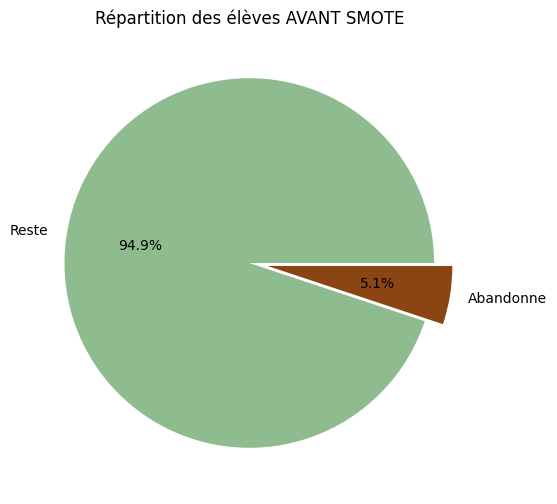

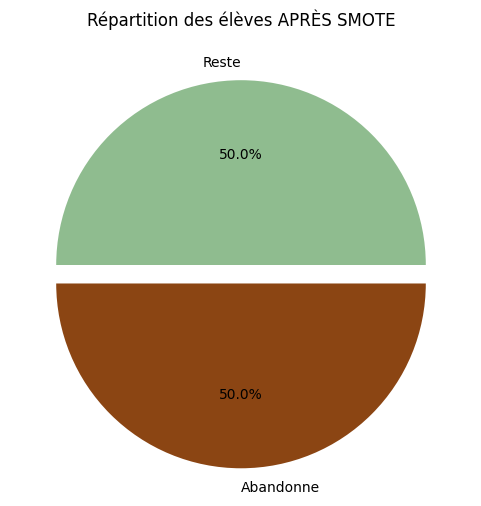

In [ ]:
# Séparer la cible et les features
y = df["risque_Abandon"]
X = df.drop("risque_Abandon", axis=1)

# Encodage des variables catégorielles
X_encoded = pd.get_dummies(X, drop_first=True)
# Répartition AVANT SMOTE
plt.figure(figsize=(6, 6))
df['risque_Abandon'].value_counts().plot.pie(
    autopct='%1.1f%%',
    labels=['Reste', 'Abandonne'],
    colors=['#8FBC8F','#8B4513'],
    explode=(0, 0.1),
    title='Répartition des élèves AVANT SMOTE',
)
plt.ylabel('')
plt.show()

# Application de SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

#  Répartition APRÈS SMOTE
plt.figure(figsize=(6, 6))
pd.Series(y_resampled).value_counts().plot.pie(
    autopct='%1.1f%%',
    labels=['Reste', 'Abandonne'],
    colors=['#8FBC8F','#8B4513'],
    explode=(0, 0.1),
    title='Répartition des élèves APRÈS SMOTE',
)
plt.ylabel('')
plt.show()

Calcul des indicateurs

In [ ]:
# 1. Indice de Difficulté Scolaire
df['Indice_Diff_Scolaires'] = (df['Nb_Notes_Sous_10'] * 0.4) + (df['Nb_Redoublements'] * 0.6)

# 2. Motivation de l’élève
df['Motivation_Elevee'] = (
    (df['Clarte_Objectifs'] == 0) &
    (df['Participation_Classe'] == 2) &
    (df['Note_Trimestre'] > 10)
)

# 3. Indice d’Absentéisme
df['Indice_Absentéisme'] = (
    (df['Absences_Non_Justifiees'] * 0.6) +
    (df['Nombre_Retard'] * 0.4)
)

# 4. Trajet Difficile
df['Trajet_Difficile'] = (
    (df['Accessibilite_Transport'] == 0) &
    (df['Temps_Trajet'] > 45)
).astype(int)  # 1 si vrai, 0 sinon

# 5. Stabilité Économique
df['Stabilite_Economique'] = (df['Revenu_Familial'] > 40000)

# 6. Stabilité Familiale
df['Situation_Familiale_Stable'] = (df['Situation_Familiale'] == 'ensemble')
# Exporter le dataset enrichi vers un nouveau fichier Excel
df.to_excel("dataset_enrichi_avec_indices.xlsx", index=False)

In [ ]:
df[['Indice_Diff_Scolaires', 'Motivation_Elevee', 'Indice_Absentéisme',
    'Trajet_Difficile', 'Stabilite_Economique', 'Situation_Familiale_Stable']].head()


,Indice_Diff_Scolaires,Motivation_Elevee,Indice_Absentéisme,Trajet_Difficile,Stabilite_Economique,Situation_Familiale_Stable
0,0.4,False,6.0,0,True,False
1,0.0,True,3.8,0,True,False
2,1.2,False,10.8,0,True,False
3,0.0,True,3.8,0,True,False
4,0.8,False,9.4,0,False,False


In [ ]:
print("\nNouveaux types de données :\n", df.dtypes)


Nouveaux types de données :
 ID_Etudiant                     int64
Note_Trimestre                float64
Nb_Notes_Sous_10                int64
Nb_Redoublements                int64
Remarques_Disciplinaires        int64
Participation_Classe            int64
Absences_Non_Justifiees         int64
Nombre_Retard                   int64
Accessibilite_Transport         int64
Zone_Habitation                 int64
Distance_Domicile_Ecole       float64
Temps_Trajet                    int64
Situation_Familiale             int64
Revenu_Familial                 int64
Comportement                    int64
Clarte_Objectifs                int64
risque_Abandon                   bool
Indice_Diff_Scolaires         float64
Motivation_Elevee                bool
Indice_Absentéisme            float64
Trajet_Difficile                int64
Stabilite_Economique             bool
Situation_Familiale_Stable       bool
dtype: object


Entrainement du modele

=== Performances des modèles ===
Modèle                    Accuracy   Precision  Recall     F1-score  
------------------------------------------------------------
Logistic Regression       0.8474     0.8173     0.8947     0.8543    
Decision Tree             0.9447     0.9568     0.9316     0.9440    
Random Forest             0.9632     0.9783     0.9474     0.9626    
SVM                       0.9526     0.9135     1.0000     0.9548    
K-NN                      0.9316     0.8796     1.0000     0.9360    
XGBoost                   0.9684     0.9785     0.9579     0.9681    
[LightGBM] [Info] Number of positive: 759, number of negative: 759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3652
[LightGBM] [Info] Number of data points in the train set: 1518, number of used features: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Gradient Boosting         0.9658     0.9784     0.9526     0.9653    
AdaBoost                  0.9395     0.9326     0.9474     0.9399    
MLP                       0.9816     0.9645     1.0000     0.9819    


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 759, number of negative: 759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3652
[LightGBM] [Info] Number of data points in the train set: 1518, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



=== Performances du Voting Classifier ===
Modèle                    Accuracy   Precision  Recall     F1-score  
------------------------------------------------------------
Voting Classifier         0.9816     0.9841     0.9789     0.9815    


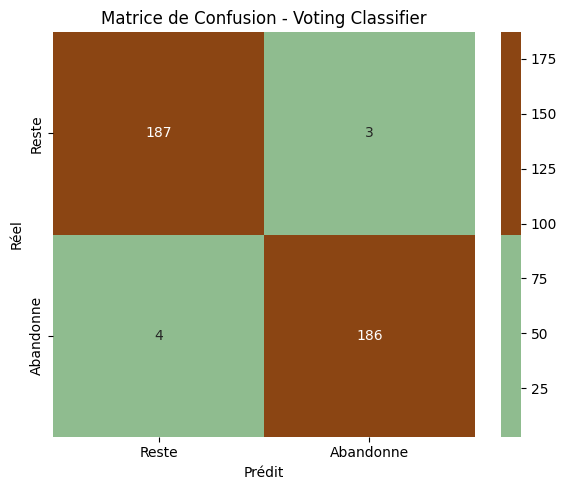

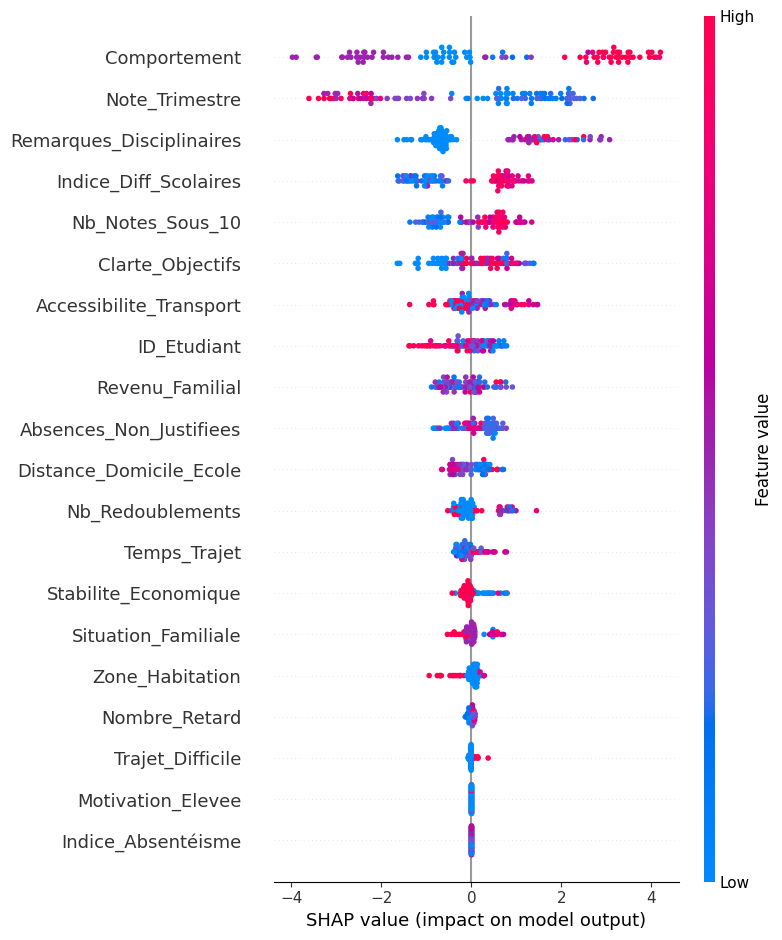

Recommandations pour l'étudiant 5:
- Orientation vers une filière mieux adaptée
- Fourniture gratuite de matériel scolaire essentiel
- Mise à disposition d’aides sociales spécifiques : bourses d’étude, repas gratuits


In [ ]:
# 1. Préparation des données ===
y = df_encoded["risque_Abandon"]
X = df_encoded.drop("risque_Abandon", axis=1)

# Standardisation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# SMOTE pour équilibrer
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Train/Test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# 2. Définition des modèles
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier,
                             GradientBoostingClassifier,
                             AdaBoostClassifier,
                             VotingClassifier)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('SVM', SVC(random_state=42)),
    ('K-NN', KNeighborsClassifier()),
    ('XGBoost', XGBClassifier(eval_metric='logloss', random_state=42)),
    ('LightGBM', LGBMClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    ('MLP', MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=500, random_state=42))
]

#  3. Évaluation des modèles
results = []
print("=== Performances des modèles ===")
print("{:<25} {:<10} {:<10} {:<10} {:<10}".format(
    'Modèle', 'Accuracy', 'Precision', 'Recall', 'F1-score'))
print("-"*60)

for name, model in models:
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calcul des métriques
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1
        })

        print("{:<25} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
            name, accuracy, precision, recall, f1))

    except Exception as e:
        print(f"Erreur avec {name}: {str(e)}")

# === 4. Création du DataFrame des résultats ===
results_df = pd.DataFrame(results).sort_values('F1', ascending=False)

# === 5. Voting Classifier avec les 3 meilleurs modèles ===
best_models = [m for m in models if m[0] in results_df.head(3)['Model'].values]
voting = VotingClassifier(
    estimators=best_models,
    voting='hard'
)

voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)

# === 6. Évaluation du Voting Classifier ===
print("\n=== Performances du Voting Classifier ===")
print("{:<25} {:<10} {:<10} {:<10} {:<10}".format(
    'Modèle', 'Accuracy', 'Precision', 'Recall', 'F1-score'))
print("-"*60)
print("{:<25} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
    'Voting Classifier',
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred),
    recall_score(y_test, y_pred),
    f1_score(y_test, y_pred)
))

# === 7. Matrice de confusion  ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap=['#8FBC8F', '#8B4513'],
            xticklabels=['Reste', 'Abandonne'],
            yticklabels=['Reste', 'Abandonne'])
plt.title('Matrice de Confusion - Voting Classifier')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.tight_layout()
plt.show()

# === 8. SHAP pour le modèle XGBoost ===
import shap

# 1. Préparer le modèle XGBoost
xgb_model = [model for name, model in models if name == 'XGBoost'][0]

# 2. Préparer un sous-échantillon de test pour expliquer
X_sample = shap.utils.sample(X_test, 100, random_state=42)  # Utilise un échantillon de 100 étudiants

# 3. Créer un explainer SHAP pour le modèle XGBoost
explainer = shap.Explainer(xgb_model)

# 4. Calculer les valeurs SHAP pour chaque étudiant de l'échantillon
shap_values = explainer(X_sample)

# 5. Visualisation des valeurs SHAP globales
shap.summary_plot(shap_values, X_sample, feature_names=X.columns)

shap.initjs()


X_sample_row = pd.DataFrame([X_sample[4]], columns=X.columns)

# Visualisation avec SHAP force plot
shap.force_plot(explainer.expected_value, shap_values[4].values, X_sample_row.iloc[0], feature_names=X.columns)

def generer_recommandations_shap(shap_values, X_sample, index, feature_names):
    recommandations = []

    # Obtenir les indices SHAP pour un étudiant donné
    shap_values_etudiant = shap_values[index]

    feature_importances = shap_values_etudiant.values  # Valeurs SHAP de l'étudiant
    features = feature_names  # Noms des caractéristiques

    # Créer un DataFrame des indices SHAP
    shap_df = pd.DataFrame(list(zip(features, feature_importances)), columns=['Feature', 'SHAP Value'])
    shap_df = shap_df.sort_values(by='SHAP Value', ascending=False)

    # Vérifier les caractéristiques ayant un impact négatif ou positif significatif
    for i, row in shap_df.iterrows():
        feature = row['Feature']
        shap_value = row['SHAP Value']

        # Recommandations en fonction des caractéristiques les plus influentes
        if feature == 'Note_Trimestre' and shap_value < 0:
            recommandations.append("Cours de rattrapage par matière problématique")
        if feature == 'Indice_Diff_Scolaires' and shap_value > 0:
            recommandations.append("Orientation vers une filière mieux adaptée")
        if feature == 'Absences_Non_Justifiees' and shap_value > 0:
            recommandations.append("Suivi régulier avec un conseiller scolaire")
        if feature == 'Remarques_Disciplinaires' and shap_value > 0:
            recommandations.append("Séances de gestion du comportement")
        if feature == 'Revenu_Familial' and shap_value < 0:
            recommandations.append("Fourniture gratuite de matériel scolaire essentiel")
            recommandations.append("Mise à disposition d’aides sociales spécifiques : bourses d’étude, repas gratuits")

    # Si aucune recommandation n'est générée, proposer des solutions générales
    if not recommandations:
        recommandations.append("Suivi personnalisé pour aider l'élève à mieux réussir.")

    return recommandations

X_sample_df = pd.DataFrame(X_sample, columns=X.columns)

# Appliquer la fonction à un étudiant particulier (par exemple, l'étudiant avec l'indice 4)
index_etudiant = 4  # L'indice de l'étudiant dans l'échantillon
recommandations = generer_recommandations_shap(shap_values, X_sample_df, index_etudiant, X.columns)

# Afficher les recommandations pour l'étudiant
print(f"Recommandations pour l'étudiant {index_etudiant + 1}:")
for recommandation in recommandations:
    print(f"- {recommandation}")
